<a href="https://colab.research.google.com/github/rtheman/TimeSeries/blob/master/RNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time-Series Forecast

A time series forecasting using Recurrent Neural Networks (RNNs).

Inspired by:
 - https://www.tensorflow.org/tutorials/structured_data/time_series#baseline

 - https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651

# 0.) Init. Environments & Libraries

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (15, 11)
mpl.rcParams['axes.grid'] = False

# 1.) Extract Data

## The weather dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected **every 10 minutes**, beginning in 2003. For efficiency, you will use only the data collected **between 2009 and 2016**. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Observations

- Total of 420,551 records

- An observation is recorded every 10 minutes.
  - Per hour, there are 6 observations
  - Per day, there are 144 (6x24) observations

If you want to predict the temperature 6 hours in the future, you'd choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model.

## Sampling Function

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

## Split Data for Training & Testing

The init. 300,000 rows of data will be **training data**, and remaining will be **validation data**.  This amounts of ~2083 days of training data.

In [ ]:
TRAIN_SPLIT = 300000

In [ ]:
# setting seed for reproducibility
tf.random.set_seed(13)

# 2.) Part 1: Forecast a univariate time series

Let's train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

We'll also make `Date Time` as the dataframe index.

Let's first extract only the temperature from the dataset.

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
# uni_data.dtype
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2ff5faeb8>],
      dtype=object)

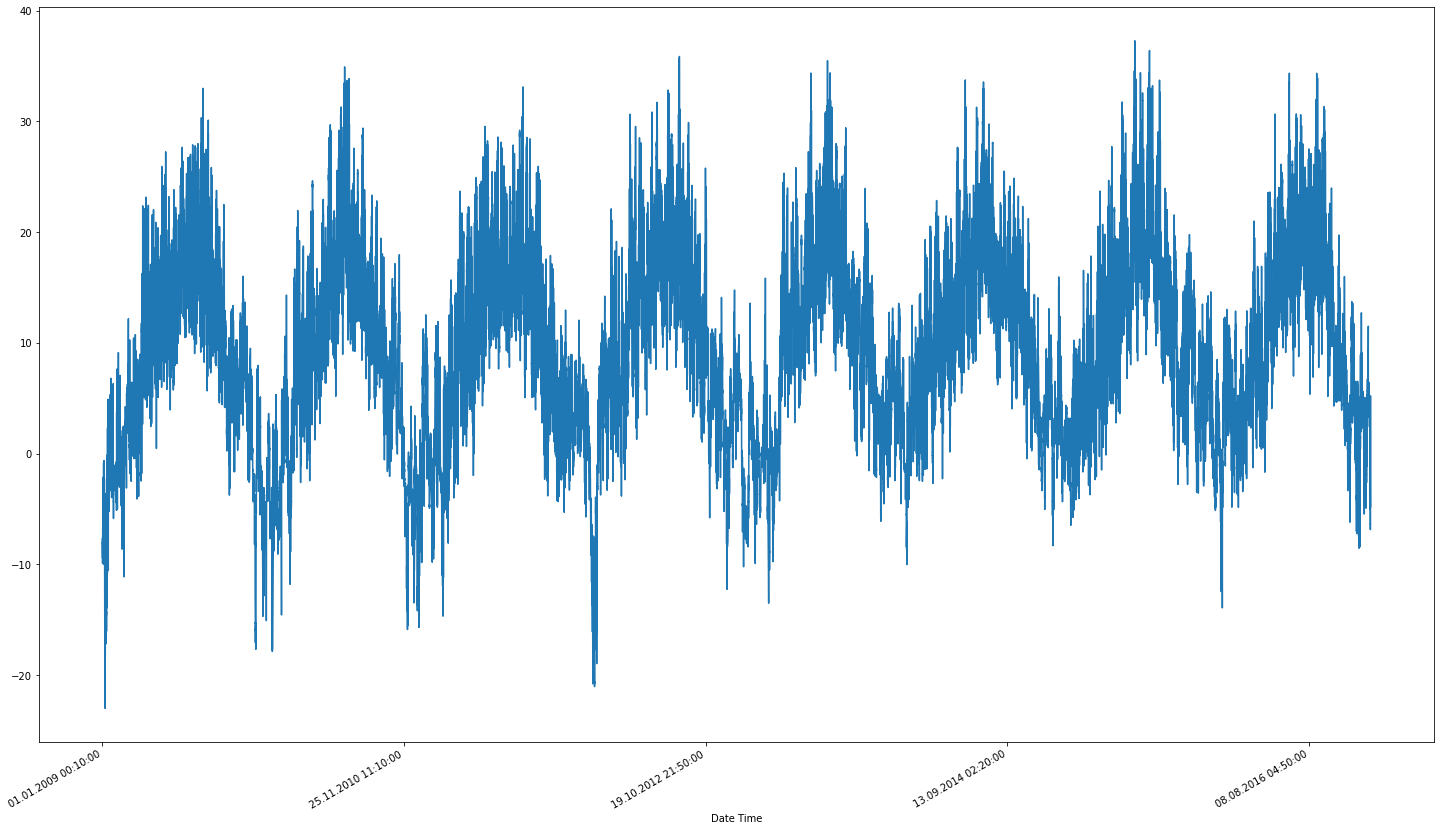

In [ ]:
mpl.rcParams['figure.figsize'] = (25, 15)
mpl.rcParams['axes.grid'] = False

uni_data.plot(subplots=True)

In [ ]:
uni_data[0]

-8.02

In [ ]:
uni_data[19]

-8.94

In [ ]:
uni_data[20]

-8.94

In [ ]:
uni_data[21]

-8.86

## xForm Dataframe to Array (temp only)

In [ ]:
uni_data = uni_data.values
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [ ]:
uni_data.size

420551

In [ ]:
uni_data[21]

-8.86

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].


## Normalize temperatures

**Note**: The mean and standard deviation should only be computed using the training data.

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std

In [ ]:
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

In [ ]:
uni_data.size

420551

In [ ]:
uni_data[0]

-1.9976629443608853

In [ ]:
uni_data[19]

-2.1041848598100876

In [ ]:
uni_data[20]

-2.1041848598100876

In [ ]:
uni_data[21]

-2.0949220845536356

In [ ]:
uni_data[299996]

0.6480172382633207

In [ ]:
uni_data[299997]

0.6445436975421511

In [ ]:
uni_data[299998]

0.6445436975421511

In [ ]:
uni_data[299999]

0.6445436975421511

In [ ]:
uni_data[300000]

0.6422280037280379

In [ ]:
uni_data[300001]

0.6364387691927553

## Create data for Univariate model

For part 1, the model will be given the **last 20 recorded temperature observations**, and needs to learn to predict the temperature at the next time step.

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [ ]:
x_train_uni.shape

(299980, 20, 1)

In [ ]:
print('Last window of past history')
print(x_train_uni[299979])
print('\n Target temperature to predict')
print(y_train_uni[299979])

Last window of past history
[[0.68391049]
 [0.68275265]
 [0.68275265]
 [0.68275265]
 [0.67696341]
 [0.67464772]
 [0.66770064]
 [0.66422709]
 [0.65959571]
 [0.65959571]
 [0.65959571]
 [0.65959571]
 [0.65612217]
 [0.65380647]
 [0.65264863]
 [0.65264863]
 [0.65264863]
 [0.64801724]
 [0.6445437 ]
 [0.6445437 ]]

 Target temperature to predict
0.6445436975421511


Now that the data has been created, let's take a look at a single example.

The information given to the network is given in blue, and it must predict the value at the red cross.

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
create_time_steps(3)

[-3, -2, -1]

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

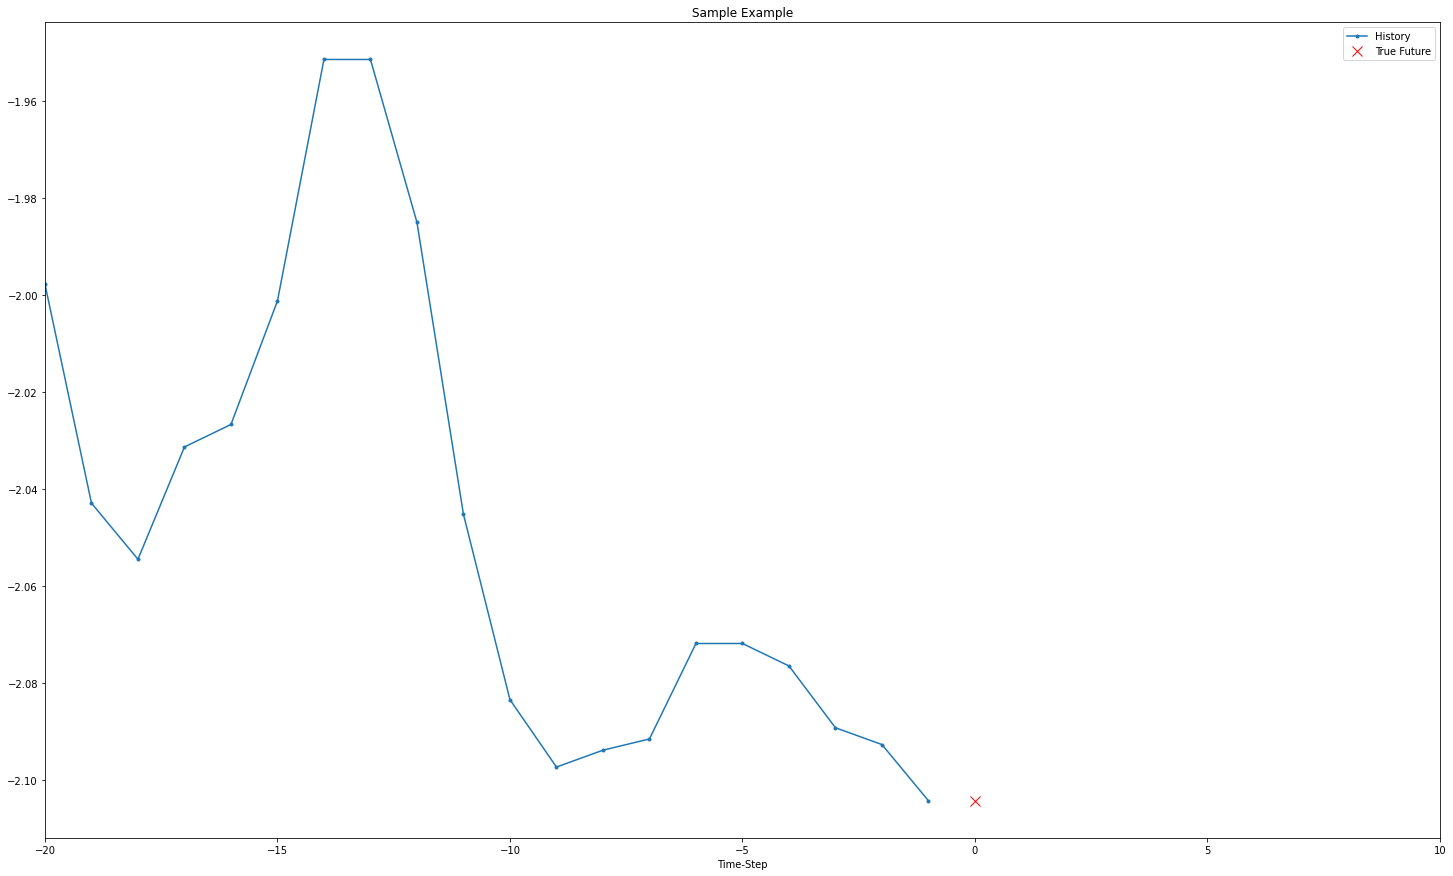

In [ ]:
# Plot the first window of dataset
show_plot(
    [x_train_uni[0], y_train_uni[0]],
    0,
    'Sample Example'
)

## a. Baseline

Before proceeding to train a model, let's first set a simple baseline. 

Given an input point, the baseline method looks at all the history and predicts the next point to be the **average of the last 20 observations**.

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

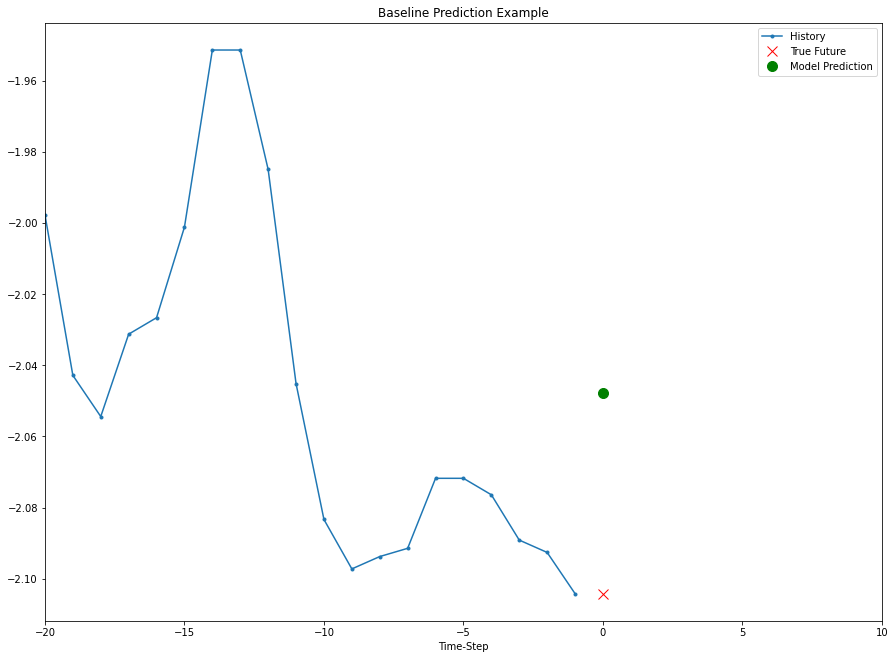

In [ ]:
show_plot(
    [x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])],
    0,
    'Baseline Prediction Example'
)

Let's see if you can beat this baseline using a recurrent neural network.

## b. Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. 

RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![alt text](https://www.tensorflow.org/tutorials/structured_data/images/time_series.png)

In [ ]:
# You will see the LSTM requires the input shape of the data it is being given.

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
# Let's make a sample prediction, to check the output of the model.

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)
